## Exploration_01
## 가위 바위 보 이미지 분류문제 (Accuracy = 98.37%)

### 1. 문제 정의
가위,바위,보 이미지를 학습하여 테스트 이미지를 입력 받았을 때


가위(0), 바위(1), 보(2)의 클래스를 올바르게 분류하는 모델을 만들어보자!

### 2. 데이터 수집 및 정의
#### 수집
- 웹캠을 사용해 가위,바위,보 각각 100장씩 촬영한 이미지 파일을 폴더에 저장한다.
- 데이터를 추가로 확보하기 위해 Notion에 공유된 데이터를 추가하여 학습에 사용하였다.
- 데이터 공유 해주신 모든 분들께 너무 너무 감사드립니다.
- 학습에 사용된 데이터는 4286장으로 가위 1427장.바위 1432장,보 1427장이다.

#### 정의
- dir_path = ~/aiffel/rock_scissor_paper/
- dir_path 하위 디렉토리로 scissor, rock, paper가 있고 그 안에 이미지들이 저장되어있다.
- image shape는 (224,224)로 mnist 이미지 사이즈와 같은 (28,28)로 resizing 되어 압축된다.
- .jpg 확장자의 이미지 파일이다.
- color image (channel=3)

### 3. 데이터 전처리
1. 카테고리(가위,바위,보)별로 저장된 이미지 데이터를 모두 target_size=(28,28)로 resizing한다.
2. img를 JPEG으로 변환한다.

In [1]:
from PIL import Image
import os
import glob

category_list = ['scissor', 'rock', 'paper'] # '가위', '바위', '보'
number_of_data = 0 #전체 데이터 수

def resize_images(category, img_path):
    images=glob.glob(img_path + "/*.jpg")
    print(f"{category} {len(images)} images to be resized.")
    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
        
    print(f"{category} {len(images)} images resized.\n")
    
for category in category_list:
    dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/"
    image_dir_path = os.path.join(dir_path, category)
    number_of_data += len(os.listdir(image_dir_path)) # 각 폴더에 있는 이미지들의 개수를 더한다.
    resize_images(category, image_dir_path)

scissor 1427 images to be resized.
scissor 1427 images resized.

rock 1432 images to be resized.
rock 1432 images resized.

paper 1427 images to be resized.
paper 1427 images resized.



In [2]:
print(number_of_data)

4286


#### 3. 함수 load_data를 정의
```
def load_data(img_path, number_of_data)
    """
    이미지가 저장된 폴더 경로를 받아 이미지 데이터와 정답 데이터를 담을 행렬을 생성하여
    반환한다.
    
    params 
    img_path : 이미지가 담겨 있는 폴더 경로
    number_of_data : 총 데이터 수 
    
    return
    imgs: 이미지데이터 (number_of_data, 28,28,3) dtype=np.int32
    labels : 정답데이터 (number_of_data,) 가위:0, 바위:1, 보:2로 라벨링, dtype=np.int32
    """
```

In [3]:
import numpy as np

def load_data(img_path, number_of_data):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
            
    print("학습데이터 이미지 개수는", idx,"입니다.")
    
    return imgs, labels

(imgs, labels) = load_data(dir_path, number_of_data)
imgs = imgs / 255.0   # 입력은 0~1 사이의 값으로 정규화

print("imgs shape: {}".format(imgs.shape))
print("labels shape: {}".format(labels.shape))

학습데이터 이미지 개수는 4286 입니다.
img shape: (4286, 28, 28, 3)
label shape: (4286,)


#### 3. 함수 custom_train_test_split 정의
-----
```
imgs, labels 데이터는 가위, 바위, 보의 순서로 이미지와 클래스가 저장되어있다.
예를들어 imgs = [가위1,가위2, .... 가위1427, 바위1, ~], labels = [0,0,0,....., 1,1, ]
테스트 데이터를 무작위 샘플링하기 위해 imgs, labels의 순서를 랜덤하게 shuffle하여
테스트 데이터를 추출한다.
```
---------
```
def custom_train_test_split(imgs, labels, test_size=0.2, shuffle=True, random_state=99)
    """
    sklearn.model_selection의 train_test_split과 비슷하게 동작한다.
    np.random.permutation()의 인자로 number_of_data를 넣어 인덱스가 random하게 shuffle되어
    test 데이터를 simple random sampling 할 수 있게 된다.
    
    params
    imgs:         이미지데이터 (4D array)
    labels:       정답데이터 (1D array)
    test_size:    테스트 데이터 비율 지정
    shuffle:      shuffle 실행유무(True/False)
    random_state: random_seed값을 고정
    
    return
    (X_train, y_train), (X_test, y_test)
    """
```

In [4]:
# imgs: 4D array, (number_of_data, 28, 28, 3)
# labels: 1D array, (number_of_data,)
def custom_train_test_split(imgs, labels, test_size=0.2, shuffle=True, random_state=99):
    test_num = int(number_of_data * test_size)
    train_num = number_of_data - test_num
    
    if shuffle: 
        np.random.seed(random_state)
        shuffled = np.random.permutation(number_of_data)
        X = imgs[shuffled,:,:,:]
        y = labels[shuffled]
        X_train = X[:train_num]
        y_train = y[:train_num]
        X_test = X[train_num:]
        y_test = y[train_num:]
    else:
        X_train = X[:train_num]
        y_train = y[:train_num]
        X_test = X[train_num:]
        y_test = y[train_num:]
        
    return (X_train, y_train), (X_test, y_test)

In [5]:
# 훈련, 테스트 데이터 생성
(X_train, y_train), (X_test, y_test) = custom_train_test_split(imgs, labels)

In [6]:
# 훈련, 테스트 데이터 shape 확인
print(X_train.shape, y_train.shape)

(3429, 28, 28, 3) (3429,)


In [7]:
# 전체 데이터 중 20%를 테스트 데이터로 추출()
print(X_test.shape, y_test.shape)

(857, 28, 28, 3) (857,)


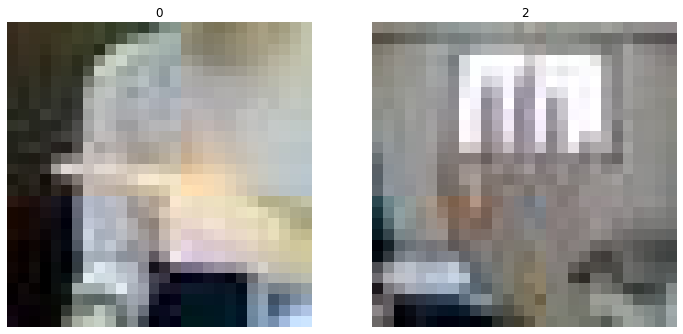

In [8]:
# imgs 데이터 imgs[0]~imgs[1426] 까지는 가위 데이터가 저장되어있다(label=0) 
# (imgs[0], labels[0])과  (X_train[0], y_train[0])을 비교해보고 데이터 순서가 바뀌었는지 확인한다.
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].imshow(imgs[0])
ax[0].axis('off')
ax[0].set_title(labels[0])

ax[1].imshow(X_train[0])
ax[1].axis('off')
ax[1].set_title(y_train[0])
plt.show()

### 4. 데이터 탐색(EDA)
1. pandas DataFrame을 이용해 label 데이터가 shuffle 되었는지 확인

In [9]:
import pandas as pd

y_train_df = pd.DataFrame(y_train, columns=['category'])
y_test_df = pd.DataFrame(y_test, columns=['category'])

In [10]:
y_train_df.head()

,category
0,2
1,2
2,2
3,0
4,0


In [11]:
y_test_df.head()

,category
0,1
1,0
2,1
3,0
4,0


#### 2. seaborn의 countplot으로 train, test 데이터 분포 확인
```
모델이 모든 클래스를 balance 하게 학습하고 분류할 수 있는지 여부를 확인할 수 있다.
train_set: 3429개 (가위:1153, 바위:1144, 보:1132)
test_set: 857개 (가위: 274, 바위: 288, 보: 295)
```

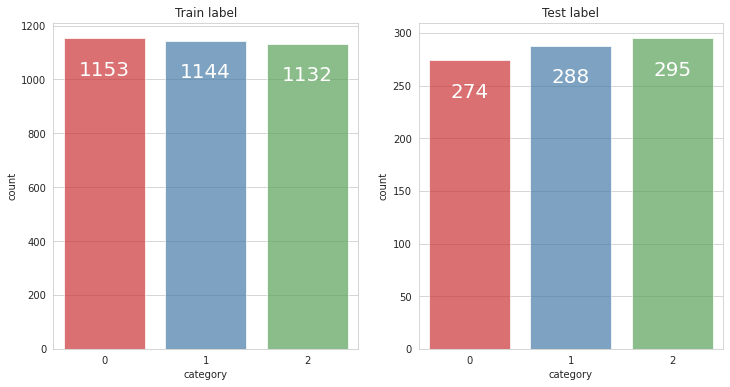

In [12]:
import seaborn as sns

sns.set_style('whitegrid')
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
ax1 = sns.countplot(x='category', data=y_train_df, palette='Set1', alpha=0.7)
ax1.set_title("Train label")

for p in ax1.patches:
    ax1.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=20)

plt.subplot(1,2,2)
ax2 = sns.countplot(x='category', data=y_test_df, palette='Set1', alpha=0.7)
ax2.set_title("Test label")

for p in ax2.patches:
    ax2.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=20)

plt.show()

### 5. 모델 구축

Basic CNN Model의 성능을 개선하기 위해 [Digit-recognizer competition](https://www.kaggle.com/c/digit-recognizer)에서 CNN을 사용해 최고의 성능을 보여준 모델을 학습에 사용하였다. 

(MNIST 99.5% 정확도)

[How to choose CNN Architecture MNIST](https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist)

-------------------
### 실험
```
1. n pairs of convolution-subsambling에서 n을 어떻게 정할 것인가?
pair를 늘릴 때 이미지 shape가 (28, 28)에서 점점 축소 되므로 max(n)=3이다.

2. How many feature maps?
n_channel_1, n_channel_2의 값을 정해야 하는데 (8,16),(16,32),(24,48),(32,64),(48,96),(64,128)을 바꿔가면서 성능을 테스트하였고 그 중 best set은 (32,64)이었다.

3. Dense layer의 unit 개수?
n_dense의 값 32, 64, 128, 256, 512, 1024, 2048 중에서 best는 128이었다.

4. dropout?
드롭아웃은 네트워크에서 과적합을 막아주는 방법으로 네트워크의 일반화 성능을 높인다.
0%, 10%, 20%, 30%, 40%, 50%, 60%, 70% 중에서 40%가 best였다.

5. kernel_size = (5,5) is the best?
필자는 1개의 kernel_size = (5,5)를 가지는 convolution layer 보다 kernel_size = (3,3)을 가지는 2개의 convolution layer를 연결시켜 비선형성을 높이는 방법을 사용했다.

6. max pooling layer
model.add(Conv2D(n_channel_1, kernel_size = 5, strides=2, padding='same', activation='relu'))에서
max pooling layer 대신 strieds=2를 사용해 subsample 하였다.

7. batch normalization
https://keras.io/api/layers/normalization_layers/batch_normalization/

8. Data augmentation

필자가 작성한 github 노트북에 다음과 같은 augmentation 코드를 확인할 수 있다.
# CREATE MORE IMAGES WITH DATA AUGMENTATION
datagen = ImageDataGenerator(
        rotation_range=15,
        zoom_range = 0.15,  
        width_shift_range=0.1, 
        height_shift_range=0.1)
        
9. 마지막 layer에서 Dense(128)가 아닌 128C4를 사용하였는데 이게 더 좋은 성능을 보여줬나보다.

```
-----------------
### 결론

```

32C3: model.add(Conv2D(n_channel_1, kernel_size = 3
32C5S2: model.add(Conv2D(n_channel_1, kernel_size = 5, strides=2

Model Architecture

784 - [32C3-32C3-32C5S2] - [64C3-64C3-64C5S2] - 128C4 - 3
with 40% dropout, batch normalization, and data augmentation added

15개의 CNN 모델을 앙상블한 결과는 이 모델(99.5%)보다 높은 99.75% 정확도를 보였다고 한다.
```
[25 Million Images! [0.99757] MNIST](https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist)

In [13]:
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization

def build_model():
    
    n_channel_1=32
    n_channel_2=64
    n_dense=128
    
    model=Sequential()
    model.add(Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(n_channel_1, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(n_channel_1, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(n_channel_2, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(n_channel_2, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(n_channel_2, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(n_dense, kernel_size = 4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(3, activation='softmax'))

    return model

### 6. 검증 데이터 분리
- 훈련(60%), 검증(20%), 테스트(20%) 데이터를 사용한다.

In [14]:
X_train_partial , X_val = X_train[:len(X_train)-len(X_test)], X_train[len(X_train)-len(X_test):]

In [15]:
print(f"학습 데이터 수: {len(X_train)}개\n검증 데이터를 제외한 학습 데이터 수 : {len(X_train_partial)}개\n검증 데이터 수: {len(X_val)}개")

학습 데이터 수: 3429개
검증 데이터를 제외한 학습 데이터 수 : 2572개
검증 데이터 수: 857개


In [16]:
y_train_partial , y_val = y_train[:len(y_train)-len(y_test)], y_train[len(y_train)-len(y_test):]

In [17]:
model = build_model()
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["acc"]
             )

In [18]:
n_train_epoch = 25

model.fit(x=X_train_partial,
          y=y_train_partial,
          epochs=n_train_epoch,
          batch_size=64,
          validation_data=(X_val, y_val))

Epoch 1/25
41/41 [==============================] - 19s 261ms/step - loss: 1.5040 - acc: 0.4438 - val_loss: 1.1598 - val_acc: 0.3162
Epoch 2/25
41/41 [==============================] - 1s 17ms/step - loss: 0.7289 - acc: 0.7225 - val_loss: 1.5468 - val_acc: 0.3162
Epoch 3/25
41/41 [==============================] - 1s 16ms/step - loss: 0.3803 - acc: 0.8581 - val_loss: 2.2087 - val_acc: 0.3022
Epoch 4/25
41/41 [==============================] - 1s 16ms/step - loss: 0.2734 - acc: 0.8966 - val_loss: 4.0805 - val_acc: 0.3162
Epoch 5/25
41/41 [==============================] - 1s 16ms/step - loss: 0.1718 - acc: 0.9385 - val_loss: 3.4033 - val_acc: 0.3536
Epoch 6/25
41/41 [==============================] - 1s 16ms/step - loss: 0.1534 - acc: 0.9439 - val_loss: 4.2083 - val_acc: 0.3512
Epoch 7/25
41/41 [==============================] - 1s 16ms/step - loss: 0.1176 - acc: 0.9586 - val_loss: 2.8499 - val_acc: 0.4142
Epoch 8/25
41/41 [==============================] - 1s 16ms/step - loss: 0.1036 -

In [19]:
history = model.history.history

In [20]:
history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

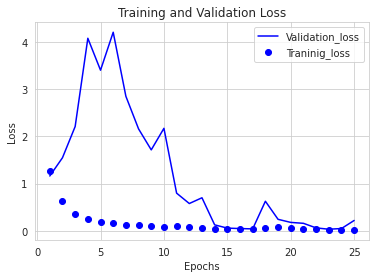

In [21]:
val_loss = history['val_loss']
loss = history['loss']
epochs = range(1, 26)

plt.plot(epochs, val_loss, 'b-', label='Validation_loss')
plt.plot(epochs, loss, 'bo', label='Traninig_loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

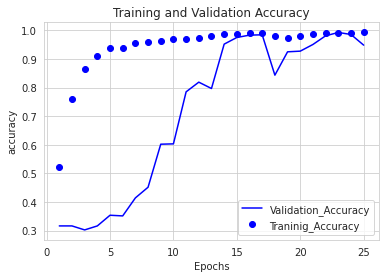

In [22]:
val_acc = history['val_acc']
acc = history['acc']
epochs = range(1, 26)

plt.plot(epochs, val_acc, 'b-', label='Validation_Accuracy')
plt.plot(epochs, acc, 'bo', label='Traninig_Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

### 7. 성능 최적화
```
epoch을 25으로 하고 매 epoch 마다 검증 데이터의 val_loss, val_accuracy를 계산하여 그래프로 나타내었다.
loss의 경우 6 epoch 이후 점점 줄어들면서 17 epoch 이후로 다시 그래프가 상승 하강을 반복하는 현상이 보인다.
accuracy도 마찬가지로 17 epoch 이후로 그래프가 하락하기 때문에 이 지점부터 overfitting을 의심 해볼 수 있다. 
따라서 epoch을 17로 재설정하고 모델을 재학습 시켜보았다.(모델을 다시 초기화하고 학습시켜야한다.)
```

In [23]:
model = build_model() # 모델 초기화
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["acc"]
             )

n_train_epoch = 17

model.fit(x=X_train_partial,
          y=y_train_partial,
          epochs=n_train_epoch,
          batch_size=64,
          validation_data=(X_val, y_val))

Epoch 1/17
41/41 [==============================] - 2s 21ms/step - loss: 1.5062 - acc: 0.4599 - val_loss: 1.1405 - val_acc: 0.3944
Epoch 2/17
41/41 [==============================] - 1s 16ms/step - loss: 0.6251 - acc: 0.7499 - val_loss: 1.2330 - val_acc: 0.3197
Epoch 3/17
41/41 [==============================] - 1s 16ms/step - loss: 0.3813 - acc: 0.8568 - val_loss: 1.3837 - val_acc: 0.3221
Epoch 4/17
41/41 [==============================] - 1s 16ms/step - loss: 0.2697 - acc: 0.9001 - val_loss: 1.4402 - val_acc: 0.3291
Epoch 5/17
41/41 [==============================] - 1s 16ms/step - loss: 0.1911 - acc: 0.9312 - val_loss: 1.4642 - val_acc: 0.4387
Epoch 6/17
41/41 [==============================] - 1s 16ms/step - loss: 0.1890 - acc: 0.9334 - val_loss: 1.5207 - val_acc: 0.4889
Epoch 7/17
41/41 [==============================] - 1s 16ms/step - loss: 0.1183 - acc: 0.9592 - val_loss: 1.5714 - val_acc: 0.4294
Epoch 8/17
41/41 [==============================] - 1s 16ms/step - loss: 0.1461 - a

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_9 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 32)       

In [25]:
results = model.evaluate(X_test, y_test)

27/27 [==============================] - 4s 4ms/step - loss: 0.0551 - acc: 0.9837


## 8. 예측
#### 모델은 첫번째 테스트 사진을 어떻게 예측했을까?

In [26]:
predictions = model.predict(X_test)

In [27]:
# 모델이 예측한 첫번째 사진의 정답은? (두근두근)
np.argmax(predictions[0])

1

라벨:  1


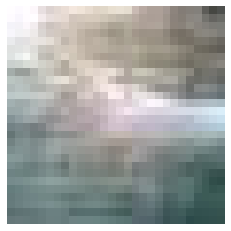

In [29]:
# 저는 이 사진 뭔지 모르겠는데 바위라고 합니다... 여러분 잘 보이시나요? ㅠ_ㅠ 
plt.imshow(X_test[0])
plt.axis('off')
print('라벨: ', y_test[0])
plt.show()

### 9. 결과해석 및 회고

```
테스트 셋 837개를 사용한 모델의 성능은 정확도 98.37%를 보여주었다.
predictions = model.predict(X_test)으로 predictions에는 모델이 예측한 이미지의 클래스가 담기게 되고
우리는 이제 X_test의 이미지와 실제 label값, 예측 label값을 비교해볼 수 있다.

분명히 Basic CNN도 이미지 분류에 꽤 좋은 성능을 보이지만, Chris Deotte씨가 설계한 이 CNN 모델의
성능은 놀라움을 주었다. kernel_size, n_dense, Convolution layer의 개수 설정 방법과 같이
하이퍼 파라미터를 어떻게 디테일하게 설정하고 layer를 연계할 수 있는지 통찰력을 얻을 수 있는 의미있는 실험이었다. 
많이 배웠고 앞으로 끊임없이 질문하는 사고가 필요할 것 같다.
```